In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import random

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import ggplot as R

from functools import reduce
import operator

import jieba.analyse
import jieba
from opencc import OpenCC #繁簡轉換

from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## preprocessing/ EDA

#### read reviews data

In [2]:
dirPath = 'C:/Users/danie/OneDrive/桌面/CIP project/data/LDA/Foreign/'
print(os.listdir(dirPath),'\n')
# result = [os.listdir(os.path.join(dirPath, f)+'/') for f in os.listdir(dirPath)]
# print(result)

['Ally(google).csv', 'Ally.csv', 'eToro(google).csv', 'eToro.csv', 'Etrade(google).csv', 'Etrade.csv', 'Fidelity(google).csv', 'Fidelity.csv', 'Firstrade(google).csv', 'Firstrade.csv', 'IBKR(google).csv', 'IBKR.csv', 'Robinhood(google).csv', 'Robinhood.csv', 'Schwab(google).csv', 'Schwab.csv', 'Stash(google).csv', 'Stash.csv', 'TD(google).csv', 'TD.csv'] 



In [3]:
list_of_df=[]

for data in os.listdir(dirPath):
    print(data)
    df = pd.read_csv(dirPath+data)
    if 'google' in data:
        df = df.drop(['likecounts'], axis=1)
        df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, "%B %d, %Y").strftime('%Y/%m/%d'))
    else:
#         df['Content'] = df['Title']+df['Content']
        df = df.drop(['Title'], axis=1)
        df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x.split('T')[0], "%Y-%m-%d").strftime('%Y/%m/%d'))

    df.loc[:,'product'] = data

    list_of_df.append(df)

Ally(google).csv
Ally.csv
eToro(google).csv
eToro.csv
Etrade(google).csv
Etrade.csv
Fidelity(google).csv
Fidelity.csv
Firstrade(google).csv
Firstrade.csv
IBKR(google).csv
IBKR.csv
Robinhood(google).csv
Robinhood.csv
Schwab(google).csv
Schwab.csv
Stash(google).csv
Stash.csv
TD(google).csv
TD.csv


In [4]:
raw_data = pd.concat(list_of_df, ignore_index=True)
raw_data = raw_data[~raw_data['Content'].isna()].reset_index(drop=True)

In [5]:
raw_data.head()

,Name,Star,Time,Content,dev_content,product
0,Matthew Acevedo,5,2018/09/16,"App is repsonsive, fast and reliable. Have ma...",NaN,Ally(google).csv
1,art campbell,1,2020/02/16,Cannot login to the app at all...non function...,NaN,Ally(google).csv
2,Shane M,1,2019/05/16,if you want to lose money don't get this on a...,NaN,Ally(google).csv
3,Geovanny Silva,1,2019/03/06,app crashes all the time.,NaN,Ally(google).csv
4,Matthew Acevedo,5,2018/09/16,"App is repsonsive, fast and reliable. Have ma...",NaN,Ally(google).csv


In [6]:
raw_data.shape

(119577, 6)

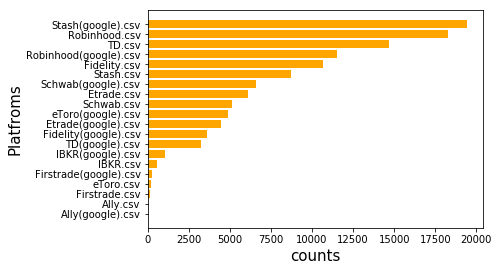

In [7]:
fig, ax = plt.subplots()
ax.barh(raw_data['product'].value_counts().index, raw_data['product'].value_counts().values,  align='center', color='orange')
ax.set_xlabel('counts', fontsize=15)
ax.set_ylabel('Platfroms', fontsize=15)
ax.invert_yaxis()  # labels read top-to-bottom



In [8]:
raw_data = raw_data.drop_duplicates().reset_index(drop=True)

In [9]:
raw_data['product'] = raw_data['product'].apply(lambda x:x.split('(')[0].split('.')[0])

In [10]:
raw_data.loc[raw_data['dev_content'].apply(lambda x:len(str(x)))<4, 'dev_content']=''

In [11]:
bar_df = pd.DataFrame(raw_data.groupby(['Star', 'product']).size()).reset_index()
bar_df = bar_df.rename(columns={0:'counts'})
bar_df.head()

,Star,product,counts
0,1,Ally,28
1,1,Etrade,4502
2,1,Fidelity,2715
3,1,Firstrade,143
4,1,IBKR,519


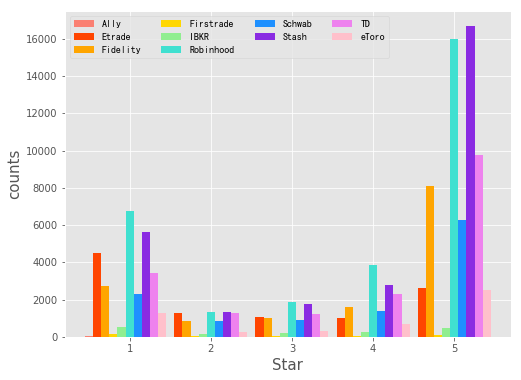

In [12]:
plt.figure(figsize=(8,6))
plt.style.use('ggplot')
myfont = FontProperties(fname=r'C:\Users\danie\OneDrive\桌面\CIP project\SimHei.ttf')

colours=['salmon', 'orangered', 'orange', 'gold', 'lightgreen', 'turquoise', 'dodgerblue', 'blueviolet', 'violet', 'pink']

for i in range(len(bar_df['product'].unique())):
    pro = bar_df['product'].unique()[i]
    x = bar_df.loc[bar_df['product']==pro,'Star']
    y = bar_df.loc[bar_df['product']==pro,'counts']

    w=0.1
    plt.bar(x-int(len(bar_df['product'].unique()))/20+0.1*i, y, width=w, align='center', label=pro, color=(colours[i]))
    
    plt.xlabel('Star',fontsize=15)
    plt.ylabel('counts',fontsize=15)
    plt.legend(prop=myfont, loc="upper left", ncol=4)



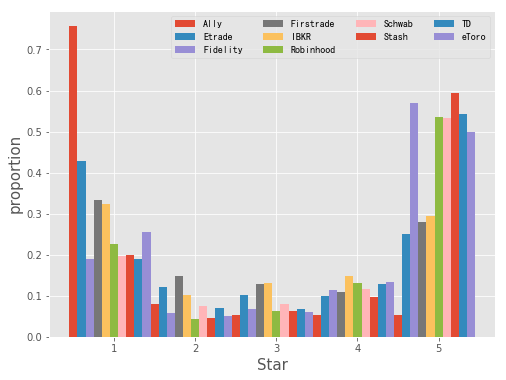

In [13]:
plt.figure(figsize=(8,6))
plt.style.use('ggplot')
myfont = FontProperties(fname=r'C:\Users\danie\OneDrive\桌面\CIP project\SimHei.ttf')

for i in range(len(bar_df['product'].unique())):
    pro = bar_df['product'].unique()[i]
    x = bar_df.loc[bar_df['product']==pro,'Star']
    y = bar_df.loc[bar_df['product']==pro,'counts']
    y /= y.sum()

    w=0.1
    plt.bar(x-int(len(bar_df['product'].unique()))/20+0.1*i, y, width=w, align='center', label=pro)

    plt.xlabel('Star',fontsize=15)
    plt.ylabel('proportion',fontsize=15)

    plt.legend(prop=myfont, loc="upper right", ncol=4)

In [14]:
raw_data['dev_content'] = raw_data['dev_content'].apply(lambda x: str(x))

In [15]:
raw_data['reply'] = (raw_data['dev_content'].apply(lambda x: len(x))>0).astype(int)

In [16]:
raw_data.groupby(['product'])['reply'].sum()/raw_data.groupby(['product'])['product'].size()

product
Ally         0.000000
Etrade       0.338529
Fidelity     0.000000
Firstrade    0.158879
IBKR         0.276119
Robinhood    0.325943
Schwab       0.006055
Stash        0.279061
TD           0.001449
eToro        0.507275
dtype: float64

In [17]:
raw_data['Y_m'] = raw_data['Time'].apply(lambda x: x[:7])

### 聲量分析

In [18]:
reply = raw_data.groupby(['product'])['reply'].sum()/raw_data.groupby(['product'])['product'].size()

In [19]:
vol_df = pd.DataFrame({'vol':raw_data.groupby(['product']).size(), 'Star':raw_data.groupby(['product'])['Star'].mean()}).reset_index()

In [20]:
vol_df = pd.merge(vol_df, pd.DataFrame(reply).reset_index(), on=['product']) 
vol_df = vol_df.rename(columns = {0:'reply'})

In [21]:
vol_df['reply'] = vol_df['reply']*100

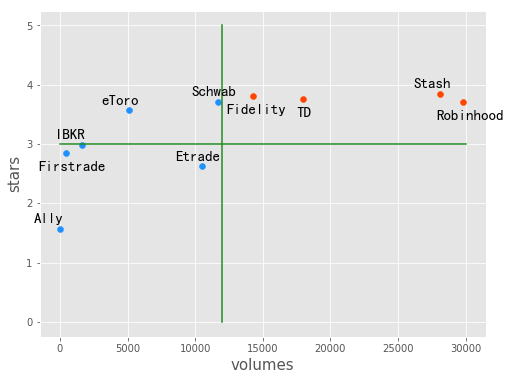

In [22]:
plt.style.use('ggplot')
# plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

myfont = FontProperties(fname=r'C:\Users\danie\OneDrive\桌面\CIP project\SimHei.ttf')

plt.figure(figsize=(8,6))

for df in vol_df.groupby(['product']):
    temp = df[1]
    label = df[0]
    if label in(['Fidelity','TD','Stash','Robinhood']):
        color = 'orangered'
    else :
        color = 'dodgerblue'
    plt.scatter(temp['vol'], temp['Star'], label=label, cmap=plt.get_cmap('Spectral'), color=color)

    for name, x ,y in zip(df[1]['product'], df[1]['vol'], df[1]['Star']):
        if label in(['Fidelity','Firstrade','Robinhood']):
            plt.annotate(name, xy=(x,y), xytext = (x-2000, y-0.3), fontproperties=myfont, size=15)
        elif label=='TD':
            plt.annotate(name, xy=(x,y), xytext = (x-500, y-0.3), fontproperties=myfont, size=15)
        else:
            plt.annotate(name, xy=(x,y), xytext = (x-2000, y+0.1), fontproperties=myfont, size=15)
            



        
plt.xlabel('volumes',fontsize=15)
plt.ylabel('stars',fontsize=15)
# plt.legend()    

plt.plot( [vol_df['vol'].mean(),vol_df['vol'].mean()], [0,5],'forestgreen')
plt.plot( [0,30000], [3,3],'forestgreen')

## 文字處理

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

In [35]:
raw_data = raw_data[(raw_data['product'].isin(['Fidelity','TD','Stash','Robinhood']))&(raw_data['Star']>3)].reset_index(drop=True)

In [36]:
raw_data

,Name,Star,Time,Content,dev_content,product,reply,Y_m
0,Mike Garnaat,4,2020/07/30,"The ""remember me"" feature is broken in the mo...",,Fidelity,0,2020/07
1,Melanie Protts,4,2020/08/01,One place for all saving and retirement needs.,,Fidelity,0,2020/08
2,Johnny Wise,5,2020/06/29,Easy to navigate and awesome customer service.,,Fidelity,0,2020/06
3,Christopher Soderman,5,2020/02/18,I love how easy the information is to access....,,Fidelity,0,2020/02
4,NMK,4,2020/02/19,Overall very good app to manage your 401k. Th...,,Fidelity,0,2020/02
...,...,...,...,...,...,...,...,...
61107,bottomfisher,4,2017/06/02,good user interface. add a.income.calculator w...,,TD,0,2017/06
61108,NCmountainhigh,5,2017/06/02,The app works very well.Gives me the info that...,,TD,0,2017/06
61109,Zoocityyticooz,5,2017/06/07,Awesome,,TD,0,2017/06
61110,Ricocurly,5,2015/01/24,Everything about the site is excellent.if you ...,,TD,0,2015/01


In [ ]:
temp = raw_data.copy()

In [ ]:
raw_data = temp.copy()

In [ ]:
# def get_ngrams(text, n ):
#     n_grams = ngrams(word_tokenize(text), n)
#     return [ ' '.join(grams) for grams in n_grams]

In [92]:
raw_data['Content'] = raw_data['Content'].apply(lambda x: nltk.word_tokenize(x.lower()))

In [94]:
sw=stopwords.words('english')
en_sw = pd.read_csv(r'C:\Users\danie\OneDrive\桌面\CIP project\data\LDA\en_sw.txt')
sw.extend(list(en_sw['en_sw']))

In [95]:
# 還原文字，並將他們依詞性分類

def get_wordnet_pos (treebank_tag):
    if treebank_tag.startswith( 'J' ):
        return wordnet.ADJ
    elif treebank_tag.startswith( 'V' ):
        return wordnet.VERB
    elif treebank_tag.startswith( 'N' ):
        return wordnet.NOUN
    elif treebank_tag .startswith( 'R' ):
        return wordnet.ADV
    else :
        return  None

    
def lemmatize (df):
    res = []
    verb = []
    adj = []
    noun = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(df['Content']):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        
        # remove punctuation and stopwords & 依照詞性區分corpus
        if word not in sw and word.isalpha():
            res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

            if get_wordnet_pos(pos) == wordnet.VERB:
                verb.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

            if get_wordnet_pos(pos) == wordnet.ADJ:
                adj.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

            if get_wordnet_pos(pos) == wordnet.NOUN:
                noun.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        
    df['Content'] = res
    df['verb'] = verb    
    df['adj'] = adj
    df['noun'] = noun
    
    return df

In [96]:
# 還原文字
raw_data = raw_data.apply(lemmatize, axis=1)

In [97]:
columns = ['Content', 'verb', 'adj', 'noun']
for col in columns:
    raw_data[col] = raw_data[col].apply(lambda x: " ".join(x))

## Keyword Extraction

In [78]:
def tfidf_extract(comment):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(comment)
    # 可以得到詞頻矩陣中所有的字
    word = vectorizer.get_feature_names()

    transformer = TfidfTransformer()
    # 將詞頻矩陣轉為tf_idf
    tfidf = transformer.fit_transform(X)

    df = pd.DataFrame({'word':vectorizer.get_feature_names(), 'tfidf':tfidf.toarray().sum(axis=0).tolist()}).sort_values(by='tfidf',ascending=False)[:10]

    return df['word'].values.tolist()

In [94]:
for App in raw_data['product'].unique():

    # 將corpus轉成詞頻矩陣
    vectorizer = CountVectorizer(ngram_range=( 1 , 3 ),  max_df=0.8, max_features=15000)
    X = vectorizer.fit_transform(raw_data[(raw_data['product']==App)&(raw_data['Star']<=3)]['Content'])
    # 可以得到詞頻矩陣中所有的字
    word = vectorizer.get_feature_names()

    transformer = TfidfTransformer()
    # 將詞頻矩陣轉為tf_idf
    tfidf = transformer.fit_transform(X)

    df = pd.DataFrame({'word':vectorizer.get_feature_names(), 'tfidf':tfidf.toarray().sum(axis=0).tolist()}).sort_values(by='tfidf',ascending=False)[:50]
    print(App)
    print(df['word'].values)
    print('\n')

C:\Users\danie\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Robinhood
['account' 'stock' 'time' 'lose' 'crash' 'trade' 'sell' 'service' 'market'
 'customer' 'buy' 'work' 'email' 'bank' 'support' 'option' 'issue' 'week'
 'platform' 'order' 'good' 'great' 'customer service' 'update' 'free'
 'price' 'bad' 'invest' 'hour' 'people' 'transfer' 'server' 'open' 'year'
 'today' 'lot' 'outage' 'cost' 'start' 'easy' 'user' 'share' 'big'
 'company' 'wait' 'fund' 'response' 'dollar' 'problem' 'phone']




In [710]:
for App in raw_data['product'].unique():

    # 將corpus轉成詞頻矩陣
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(raw_data[(raw_data['product']==App)&(raw_data['Star']>3)]['Content'])
    # 可以得到詞頻矩陣中所有的字
    word = vectorizer.get_feature_names()

    transformer = TfidfTransformer()
    # 將詞頻矩陣轉為tf_idf
    tfidf = transformer.fit_transform(X)

    df = pd.DataFrame({'word':vectorizer.get_feature_names(), 'tfidf':tfidf.toarray().sum(axis=0).tolist()}).sort_values(by='tfidf',ascending=False)[:10]
    print(App)
    print(df['word'].values)
    print('\n')

Ally
['work' 'good' 'log' 'trade' 'version' 'widget' 'change' 'complex'
 'versatility' 'ease']


eToro
['good' 'great' 'easy' 'trading' 'nice' 'platform' 'love' 'excellent'
 'awesome' 'trade']


Etrade
['great' 'easy' 'good' 'work' 'love' 'awesome' 'trade' 'stock' 'excellent'
 'trading']


Fidelity
['easy' 'great' 'love' 'good' 'work' 'account' 'awesome' 'navigate'
 'excellent' 'user']


Firstrade
['good' 'great' 'update' 'love' 'nice' 'easy' 'trade' 'stock' 'market'
 'finally']


IBKR
['great' 'good' 'trading' 'trade' 'work' 'excellent' 'option' 'easy'
 'chart' 'love']


Robinhood
['easy' 'stock' 'great' 'invest' 'love' 'trading' 'good' 'market' 'money'
 'start']


Schwab
['easy' 'great' 'work' 'love' 'good' 'deposit' 'check' 'account'
 'excellent' 'bank']


Stash
['great' 'love' 'easy' 'invest' 'money' 'good' 'save' 'awesome' 'stock'
 'learn']


TD
['easy' 'great' 'love' 'good' 'work' 'trade' 'trading' 'stock'
 'ameritrade' 'excellent']




#### read update data

In [704]:
dirPath = 'C:/Users/danie/OneDrive/桌面/Update/'
result = [f for f in os.listdir(dirPath)]
df = pd.DataFrame()
for p in result:
    temp = pd.read_csv(dirPath+p)
    temp['Product'] = p[:-4]
    df = pd.concat([df, temp], axis=0)

df = df.reset_index(drop = True)

df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime('%Y/%m/%d'))

products = df['Product'].unique()

#### 標記出分數下降的點， 並提取評論分數<3的關鍵字

Ally
2019/02/07
jieba ['crash', 'timeload', 'time']
tf_idf ['time', 'crash', 'load']
['crash time', 'crash time', 'load time']
2019/03/27
jieba ['login', 'password', 'log', 'crash', 'money', 'correct', 'website', 'problem', 'reset', 'recognize']
tf_idf ['log', 'login', 'crash', 'unable', 'password', 'good', 'update', 'shut', 'money', 'time']
['crash load personal crash delete reinstall time continue', 'login functional good', 'unable log log credential website fail']
2020/06/10
jieba ['scrap', 'charge', 'amex']
tf_idf ['amex', 'charge', 'scrap']
['scrap charge amex', 'scrap charge amex', 'scrap charge amex']




<Figure size 432x288 with 0 Axes>

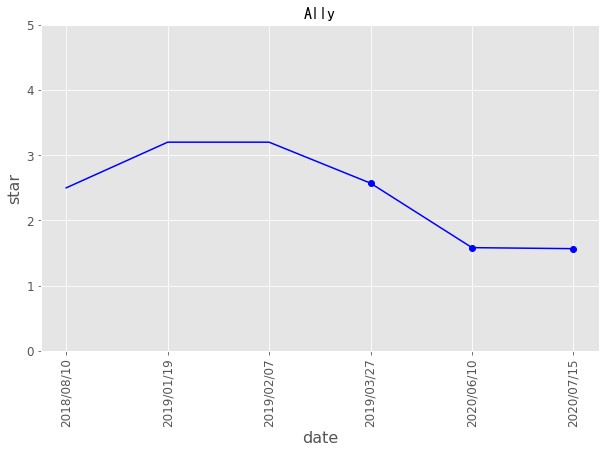

eToro
2019/11/27
jieba ['sell', 'account', 'buy', 'load', 'exchange', 'easy', 'couple', 'step', 'monitor', 'market']
tf_idf ['sell', 'trade', 'load', 'exchange', 'bad', 'start', 'veision', 'close', 'money', 'pending']
['veision bad provide status user buy sell bring veision', 'stressful experience vex money proof address proof addition offer stock option understood', 'prends une grande marge sur vous mettez sur à fuir il mieux']
2019/12/30
jieba ['price', 'dollar', 'buy', 'bitcoin', 'money', 'notification', 'delete', 'actual', 'high', 'worth']
tf_idf ['interested', 'steal', 'balance', 'outstanding', 'notification', 'money', 'price', 'binary', 'option', 'currency']
['steal outstanding balance', 'digital currency binary option', 'comment delete buy price actual buy price dollar high buy dollar worth bitcoin drop real price dollar automatic loss watch price bitcoin device reviewsomehow comment delete buy price actual buy price dollar high buy dollar worth bitcoin drop real price dollar au

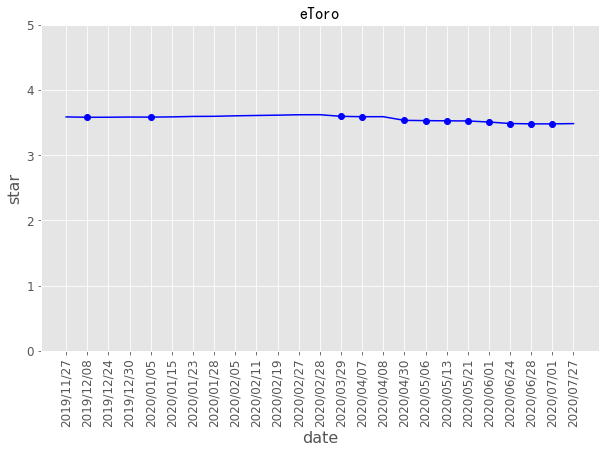

Etrade
2019/02/21
jieba ['account', 'time', 'order', 'stock', 'navigate', 'phone', 'trading', 'work', 'customer', 'money']
tf_idf ['account', 'time', 'navigate', 'difficult', 'work', 'hard', 'easy', 'trade', 'stock', 'option']
['extremely glitchy sign process refill sign time save progress exit respond text start hinderance link bank account mobile bank exit info behold return log account add account user friendly bad', 'love open frozen time piece trash', 'friendly coaching guide start figure add money start buying boo frustrating']
2019/04/24
jieba ['account', 'stock', 'transfer', 'money', 'withdraw', 'trade', 'option', 'customer', 'constantly', 'wire']
tf_idf ['account', 'stock', 'impressed', 'suck', 'option', 'statement', 'capital', 'transfer', 'money', 'simple']
['mind customer savvy age easily pass option classic portfolio work mehta', 'frequently deny access portfolio customer service incredibly slow resolve issue force close account bc unauthorized gross mishandling personal ca

tf_idf ['money', 'time', 'account', 'slow', 'work', 'load', 'log', 'update', 'trade', 'stock']
['worth', 'transfer money bank messaging time hour', 'slow clunky disconnect internet pixel garbage']
2020/07/23
jieba ['update', 'wait', 'info', 'account', 'money', 'stock', 'time', 'chat', 'trading', 'portfolio']
tf_idf ['work', 'account', 'update', 'money', 'bad', 'chat', 'stock', 'wait', 'time', 'slow']
['company impossible contact chat service ridiculous wait time wait chat rep magically number wait time ridiculous trading company disappointed', 'bad customer service', 'easy transfer money rare time transfer money sort error encounter chat function kick wait long minute kick queue eat couple hour morning']




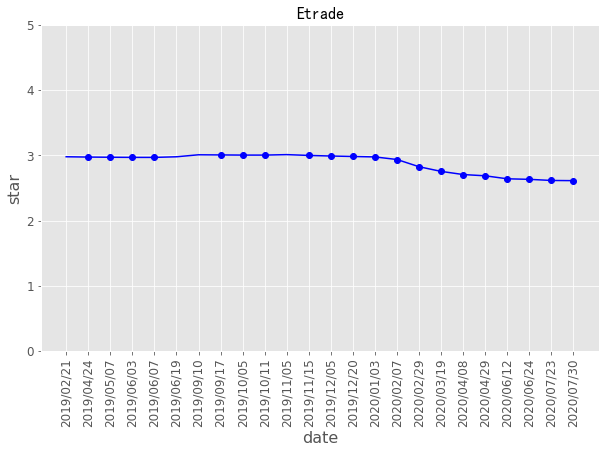

Fidelity
2018/12/05
jieba ['account', 'log', 'work', 'check', 'update', 'time', 'picture', 'phone', 'change', 'version']
tf_idf ['work', 'account', 'log', 'time', 'version', 'check', 'update', 'open', 'good', 'change']
['work note work fine update fixed revert version', 'star finally accept photo check fiance phone waste hour time complicate lighting tripod setup black cloth background severely eat battery time hire dev functio reviewi star finally accept photo check fiance phone waste hour time complicate lighting tripod setup black cloth background severely eat battery time hire dev functional', 'face recognition fingerprint log']
2019/01/22
jieba ['check', 'account', 'work', 'feature', 'picture', 'time', 'change', 'photo', 'upload', 'rollover']
tf_idf ['work', 'check', 'time', 'account', 'crash', 'picture', 'phone', 'update', 'deposit', 'change']
['issue update error whatnot log fingerprint sensor manually entering password reboot phone issue start', 'camera feature awful photo chec

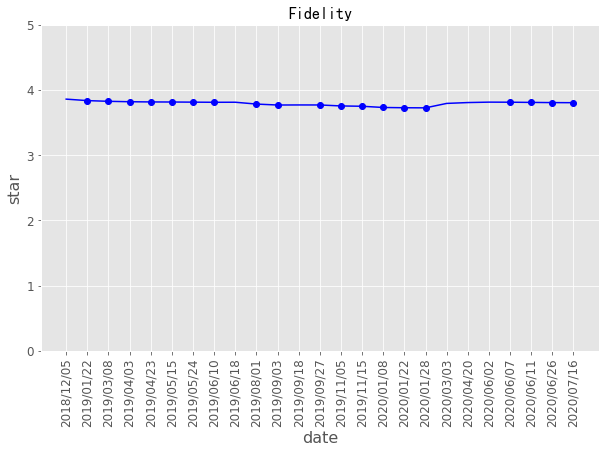

Firstrade
2015/01/26
jieba ['digit', 'stock', 'list', 'star']
tf_idf ['digit', 'list', 'star', 'stock']
['digit stock list digit star', 'digit stock list digit star', 'digit stock list digit star']
2015/03/27
jieba ['benefit', 'mobile', 'repeatedly', 'fail', 'authenticate', 'login', 'reliable', 'tech', 'support']
tf_idf ['authenticate', 'benefit', 'fail', 'login', 'mobile', 'reliable', 'repeatedly', 'support', 'tech']
['benefit mobile repeatedly fail authenticate login reliable tech support', 'benefit mobile repeatedly fail authenticate login reliable tech support', 'benefit mobile repeatedly fail authenticate login reliable tech support']
2015/10/22
jieba ['option', 'limit', 'control', 'view', 'dividend', 'purchase', 'price', 'remove', 'phoneselect', 'trade']
tf_idf ['option', 'phone', 'io', 'select', 'trade', 'type', 'control', 'dividend', 'limit', 'price']
['limit option control option view dividend purchase price remove phone', 'limit option control option view dividend purchase pr

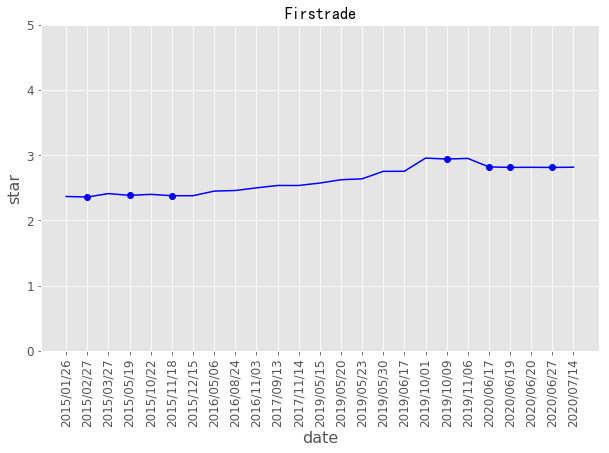

IBKR
2018/11/23
jieba ['time', 'option', 'account', 'trade', 'user', 'order', 'log', 'real', 'address', 'ib']
tf_idf ['time', 'log', 'work', 'account', 'option', 'trade', 'user', 'server', 'horrible', 'display']
['display close price', 'hell challenge platform imposible lot error disconnection dont requirement totally rubish client support horrible idiot training', 'issue option spread spread tab option chain head nolonger frozen expiry scroll check selected ootions issue option tab display strike reviewissue option spread spread tab option chain head nolonger frozen expiry scroll check selected ootions issue option tab display strike strike close stock contacted support day progress issue']
2019/02/12
jieba ['feature', 'order', 'pricing', 'user', 'mobile', 'check', 'trade', 'edit', 'quote', 'slow']
tf_idf ['order', 'mobile', 'check', 'feature', 'user', 'pricing', 'trade', 'quote', 'edit', 'load']
['ui intuitive bloat feature feel excessive mobile check portfolio', 'etf pricing inaccur

tf_idf ['money', 'terrible', 'chart', 'bad', 'install', 'slowbugsetc', 'account', 'minute', 'lose', 'trading']
['chart price lag market minute problem day trader', 'terrible application chart freezing lose money compare inaccurate wrong trade scanner bad useless android window', 'minute chart work']
2020/04/28
jieba ['time', 'trading', 'limit', 'account', 'fund', 'phone', 'money', 'login', 'order', 'bot']
tf_idf ['login', 'time', 'account', 'buggy', 'update', 'price', 'stock', 'bad', 'connect', 'server']
['slow lookup option auto price current market price time', 'dont nigerian trader register country residence country nigeria totally unfair crook nigerian crook wrong thinking nigeria reviewyou dont nigerian trader register country residence country nigeria totally unfair crook nigerian crook wrong thinking nigeria big potential market africa', 'waste time buggy install login']
2020/05/14
jieba ['update', 'complete', 'work', 'annual', 'transfer', 'mobile', 'ib', 'stick', 'default', 'li

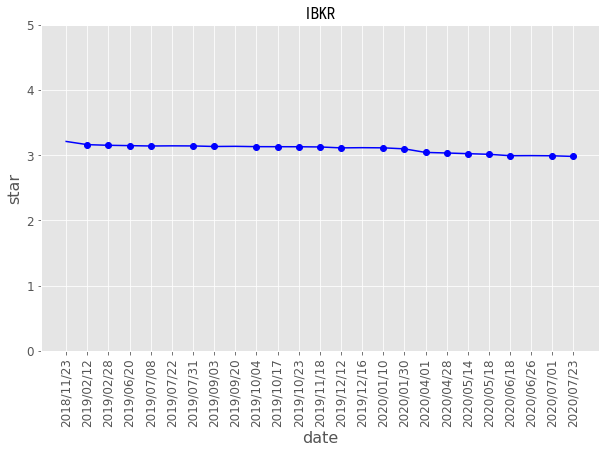

Robinhood
2020/03/02
jieba ['day', 'money', 'lose', 'trading', 'market', 'time', 'trade', 'sell', 'crash', 'stock']
tf_idf ['day', 'money', 'crash', 'lose', 'trading', 'time', 'trade', 'market', 'sell', 'server']
['connectivity absolutely horrid single morning market open plenty apps commission free trading', 'completely trading day cost', 'confidence ruin today massive hour long outage ongoing volatile time startup acceptable people lose money']
2020/04/10
jieba ['day', 'account', 'money', 'email', 'stock', 'customer', 'bank', 'time', 'invest', 'info']
tf_idf ['account', 'money', 'day', 'stock', 'customer', 'bank', 'support', 'invest', 'email', 'week']
['total disaster transfer max daily time message fund day bank account withdraw day request msg msg box transfer reviewtotal disaster transfer max daily time message fund day bank account withdraw day request msg msg box transfer exact day fund day time transfer fund day withdraw', 'terrible server weekly severely impact', 'extremely un

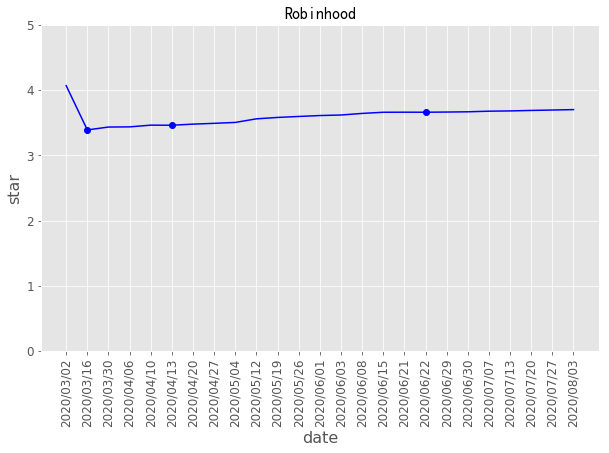

Schwab
2019/08/29
jieba ['iphone', 'crash', 'time', 'log', 'login', 'work', 'pro', 'account', 'io', 'check']
tf_idf ['crash', 'login', 'log', 'iphone', 'io', 'time', 'pro', 'work', 'account', 'ios']
['honestly difficult lookup function buy investment difficult deposit check wait clear option investment industry figure buy contribute roll fee associate situation additional money', 'win login upgrade iphone enter password click login crash massively frustrating', 'sign check account crashing']
2019/09/25
jieba ['login', 'io', 'crash', 'work', 'access', 'log', 'password', 'reinstall', 'upgrade', 'deposit']
tf_idf ['crash', 'login', 'io', 'work', 'iphone', 'open', 'update', 'log', 'ios', 'time']
['iphone io crash login', 'apple io login crash time', 'unusable io']
2020/03/31
jieba ['deposit', 'portfolio', 'time', 'issue', 'check', 'track', 'performance', 'bank', 'focus', 'fail']
tf_idf ['trade', 'time', 'crash', 'update', 'apps', 'late', 'graph', 'freeze', 'mobile', 'deposit']
['mobile che

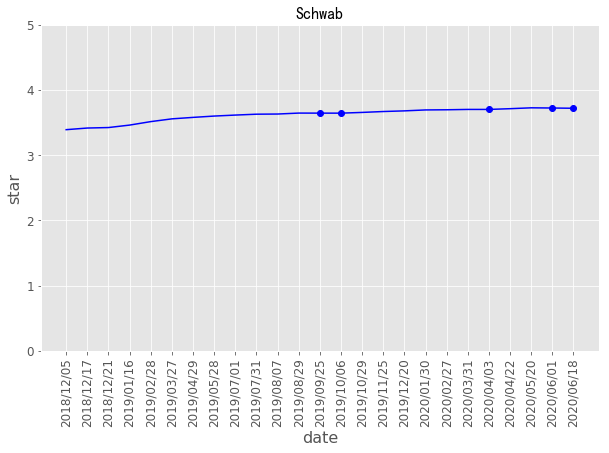

Stash
2020/02/10
jieba ['account', 'money', 'bank', 'service', 'email', 'customer', 'time', 'day', 'month', 'charge']
tf_idf ['account', 'money', 'bank', 'cancel', 'service', 'time', 'email', 'close', 'charge', 'month']
['money account mysteriously lock talk update number dollar mon acct consent tsk tsk tsk shady business', 'sign phone number change sign january problem longer sign extremely piss problem wo download space reviewwill sign phone number change sign january problem longer sign extremely piss problem wo download space update uninstalling longer', 'uninstalled reinstall open']
2020/02/18
jieba ['account', 'money', 'stock', 'bank', 'invest', 'lock', 'time', 'week', 'email', 'charge']
tf_idf ['money', 'account', 'cancel', 'trash', 'service', 'bank', 'transfer', 'week', 'lock', 'charge']
['bad money account randomly', 'remove external bank account', 'hate transfer transfer investment profit transfer debit week add process understand bank transfer long']
2020/02/24
jieba ['accou

jieba ['account', 'bank', 'money', 'day', 'stock', 'cancel', 'email', 'service', 'close', 'invest']
tf_idf ['account', 'money', 'cancel', 'bank', 'work', 'email', 'bad', 'invest', 'close', 'stock']
['cancel account', 'close legal illegitimate business invest year small money meet exceed growth goal support atrocious center barely legible people work single shift office escalate answer specific question technology suspect touting investment slow portfolio opaque support basic forget multiple bank account trouble link customer service generally clueless technical troubleshooting happen script fail link bank account website unable provide tracking number cheque mail money fact idea security account close business day cheque week send live regular mail tracking stay plenty good free roboadvisors junk service', 'horrible account lock open blessing disguise close account bank block money uninstalled customer service whatsoever faq reviewhorrible account lock open blessing disguise close acco

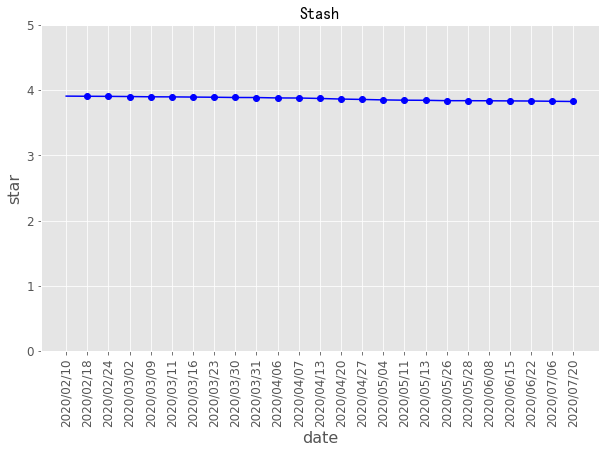

TD




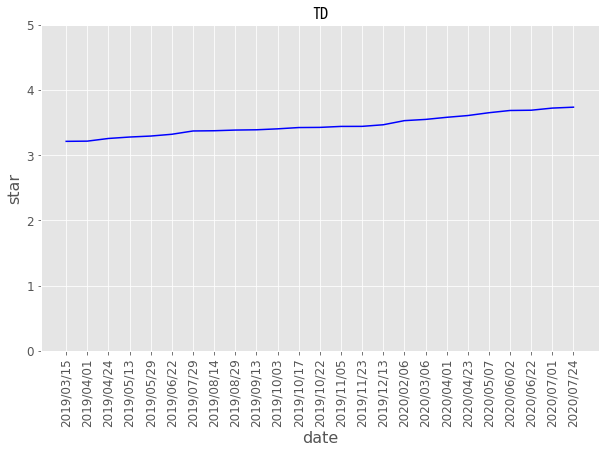

In [705]:
plt.style.use('ggplot')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=.5)
# myfont = FontProperties(fname=r'C:\Users\danie\OneDrive\桌面\SimHei.ttf')

for i in range(len(products)):
    datelist = df[df['Product']==products[i]]['Date']
    datelist = datelist.sort_values().reset_index(drop=True)
    subset = raw_data[raw_data['product'] == df['Product'].unique()[i]]
    update_star = [(subset[subset['Time']<datelist[i]]['Star'].mean(), datelist[i]) for i in range(len(datelist))]
    update_star = pd.DataFrame(update_star)
    update_star.columns = ['star', 'date']
    update_star['label'] = update_star['star'].shift(-1)
    update_star['label'] = (update_star['label']<update_star['star']).values.astype(int)
    update_star['label'] = update_star['label'].shift(1).fillna(0)
    update_star['product'] = products[i]
      
    print(products[i])
    for date_idx in np.nonzero(update_star['label'].values==1)[0]:
        print(update_star['date'].tolist()[date_idx-1])
        comment = subset[(subset['Time']>=update_star['date'][date_idx-1])&(subset['Time']<update_star['date'][date_idx])&(subset['Star']<3)]['Content'].values
        print('jieba',jieba.analyse.extract_tags(reduce(operator.concat, comment), topK=10, withWeight=False, allowPOS=()))
        print('tf_idf',tfidf_extract(comment))
        print(random.choices(comment, k=3))
    print('\n')
    
    markers_on=np.nonzero(update_star['label'].values)[0]
    fig,ax = plt.subplots(1, 1, figsize=(10,6))
#     ax = plt.subplot(5, 2, i+1)
    ax = plt.subplot(1, 1, 1)
    plt.ylim(0, 5)
    plt.title(products[i],  fontproperties=myfont, size=16)
    plt.plot(update_star['date'], update_star['star'], '-bo', markevery=markers_on.tolist())
    plt.xlabel('date', size=16)
    plt.ylabel('star', size=16)
    plt.xticks(rotation=90, size=12)
    plt.yticks(size=12)

    plt.show()


In [66]:
raw_data['Content'][100]

" Poor user experience. Very easily lost in both the app and browser. There's no obvious way to withdraw or deposit crypto to/from external wallets. Was lured in with the promise of $50 after my first trade (which I've successfully made), but I haven't received it"

## Word Cloud

https://tinyurl.com/yx9evhct

In [98]:
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud

In [99]:
mask_color = np.array(Image.open(r'C:\Users\danie\OneDrive\桌面\圖片2.jpg')) #文字雲形狀
mask_color = mask_color[::3, ::3]
mask_image = mask_color.copy()
mask_image[mask_image.sum(axis=2) == 0] = 255


# Edge detection
edges = np.mean([gaussian_gradient_magnitude(mask_color[:, :, i]/255., 2) for i in range(3)], axis=0)
mask_image[edges > .08] = 255

### Star < 3

In [106]:
cloud_data = raw_data[(raw_data['product'].isin(['Fidelity','TD','Stash','Robinhood']))&(raw_data['Star']>3)].reset_index(drop=True)
cloud_data.head()

,Name,Star,Time,Content,dev_content,product,reply,Y_m,verb,adj,noun
0,Mike Garnaat,4,2020/07/30,remember feature break mobile browser interfac...,,Fidelity,0,2020/07,remember break support save ids work work,mobile mobile,feature browser interface user couple year
1,Melanie Protts,4,2020/08/01,place saving retirement,,Fidelity,0,2020/08,,,place saving retirement
2,Johnny Wise,5,2020/06/29,easy navigate awesome customer service,,Fidelity,0,2020/06,navigate awesome,easy,customer service
3,Christopher Soderman,5,2020/02/18,love easy access convenient button alter contr...,,Fidelity,0,2020/02,love alter track track love alter track track ...,easy convenient great easy convenient great tr...,access button contribution account hsas stock ...
4,NMK,4,2020/02/19,good manage basic view balance navigate easily...,,Fidelity,0,2020/02,manage view route navigate work manage view ro...,good navigate mobile solid good navigate mobil...,basic balance function pc version website bit ...


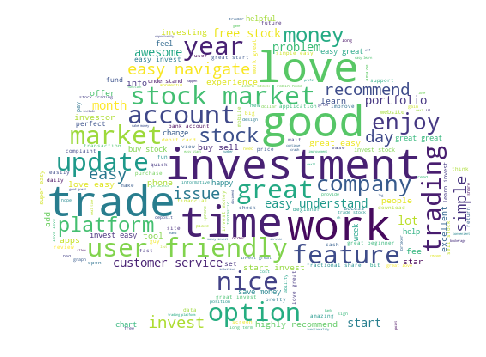

In [111]:
plt.figure(figsize=(8,6))
word_bag = " ".join(cloud_data.loc[:, 'Content'].tolist())

#背景顏色預設黑色，改為白色、使用指定圖形、使用指定字體
my_wordcloud = WordCloud(background_color='white',mask=mask_image, max_font_size=50,
               random_state=42, relative_scaling=0).generate(word_bag)

plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()

### Star > 3

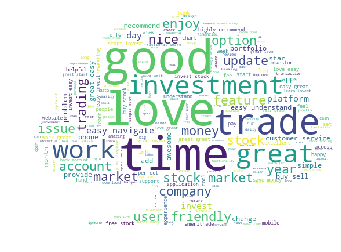

In [709]:
word_bag = " ".join(raw_data.loc[raw_data['Star']>3, 'Content'].tolist())

#背景顏色預設黑色，改為白色、使用指定圖形、使用指定字體
my_wordcloud = WordCloud(background_color='white',mask=mask_image, max_font_size=80,
               random_state=42, relative_scaling=0).generate(word_bag)

plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()